## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]


In [5]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [6]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key='Bd2JpsiKS')

In [7]:
# Read data and fit it
dataset_file_name = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/interim.root'
data = ROOT.TFile(dataset_file_name)
dataset_tree = data.Get('Bd2JpsiKS') 
dataset_tree.GetEntries()



203016

In [8]:
signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()

6.1676589792857133

### Function to calculate the FOMs

### Configure  and define cuts 

In [126]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

cuttype = 'BDTresponse_wrongPV' 

cuts = np.linspace(4,6.1,50) #(0,20,10)    #(0,0.001,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [127]:
def calculate_foms(data_fit_cut,sig_yields_init): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    timeres_power = 0
    tagging_power = 0
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)

    
    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(data_fit_cut['Delta_TAU'])) 
    
    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    print(efficiency)
    ##################################################################
    
    for i in range(data_fit_cut.shape[0]):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
    
        timeres_power     += timeerror_dilution *signal_weight 
        
        timeres_power /= signal_sum  
        
    tagging_power /= signal_sum
    timeres_power /= signal_sum

    
    
    fomname_to_value = {
    
        'TimeresPower' : timeres_power,
        'Efficiency'   : efficiency
    }

    return fomname_to_value

(array([  7.36800000e+03,   9.00700000e+03,   1.55730000e+04,
          9.08600000e+03,   1.17790000e+04,   8.17300000e+03,
          1.02470000e+04,   7.91000000e+03,   9.65200000e+03,
          1.44480000e+04,   1.43130000e+04,   1.28910000e+04,
          1.66410000e+04,   3.85620000e+04,   8.57530000e+04,
          1.19569000e+05,   4.44330000e+04,   1.66430000e+04,
          1.05000000e+02,   4.50000000e+01]),
 array([ 4.00001767,  4.10839973,  4.2167818 ,  4.32516386,  4.43354593,
         4.54192799,  4.65031006,  4.75869213,  4.86707419,  4.97545626,
         5.08383832,  5.19222039,  5.30060245,  5.40898452,  5.51736659,
         5.62574865,  5.73413072,  5.84251278,  5.95089485,  6.05927691,
         6.16765898]),
 <a list of 20 Patch objects>)

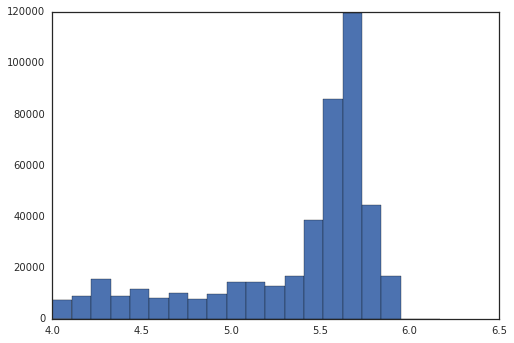

In [128]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(signal_dataframe_wrongPV['BDTresponse_wrongPV'],20)

In [ ]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

In [ ]:
from ROOT import RooArgList
import subprocess, os
import time
import root_pandas as rp

x=None


sig_yields_init = signal_dataframe_wrongPV.shape[0]

for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    #best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
    #data_fit_cut = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6')
    #print("The size of the sample is:")
    #print(data_fit_cut['Delta_TAU'].min())
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
   
    
    foms = calculate_foms(data_fit_cut,sig_yields_init)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut BDTresponse_wrongPV>4.0
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper


### Plot FOMs

In [ ]:
cut_to_performance

In [ ]:
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
foms_to_plot["TimeresPower"] = "BDT PV selection"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    x=ys[parameter]
    values = ys['TimeresPower']
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("wPV BDT cut")

plt.gca().set_ylim(0.,1.0)
plt.gca().set_xlim(4,6.5)
plt.legend(loc='best')
plt.savefig(subdir + '/FOMS.pdf')
plt.show()

In [ ]:
import seaborn as sns; sns.set_style('white')

x, ys = unpack_cut_dict(cut_to_performance)
test = pd.DataFrame()
test['TimeresPower'] = np.array(ys['TimeresPower'])
test['Efficiency'] = np.array(ys['Efficiency'])


y_lim = (0,1)
x_lim = (0.0003,1)
g = sns.jointplot(x='TimeresPower', y='Efficiency',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")
#g.savefig("/home/chasenberg/plots/wrong_pv/deltatau_vs_pvzpull.pdf")
print(test.shape)

In [ ]:

a = test['TimeresPower']
plt.plot(a)

In [ ]:
test['TimeresPower'].min()

In [ ]:
values

In [ ]:
x